# Tutorial: Class Activation Maps for Semantic Segmentation
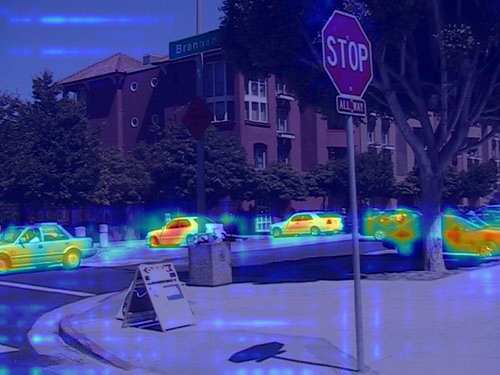

For Semantic Segmentation models, the model predicts these scores for every pixel in the image.
We need to compute the Class Activation MAP with respect to some target.
Usually the target to maximize the score of one of the categories.

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from torchvision.models.segmentation import deeplabv3_resnet50
import torch
import torch.functional as F
import numpy as np
import requests
import torchvision
from PIL import Image
import re
from torchsummary import summary
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from danet import get_danet


image = "1a0qp3_c8t8jtf_0.jpg"
image = np.array(Image.open(image))
rgb_img = np.float32(image) / 255
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

image = image.reshape((-1, image.shape[-3], image.shape[-2], image.shape[-1]))
# print(f"test shape {img.shape}") #(1, 512, 512, 3)
# image = direct_val(image)

# Taken from the torchvision tutorial
# https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html
# model = deeplabv3_resnet50(pretrained=True, progress=False)

model = get_danet(backbone='resnet50', pretrained_base=False, nclass=1)

model_path = './model_8.pt'
checkpoint = torch.load(model_path, map_location='cpu')
# strict=true 为原始代码
model.load_state_dict({re.sub("^module.", "", k): v for k, v in checkpoint['model_dict'].items()}, strict=True)

# img = img.reshape((-1, img.shape[-3], img.shape[-2], img.shape[-1]))
# summary(model, (512, 512, 3))
print(model)

model = model.eval()

if torch.cuda.is_available():
    model = model.cuda()
    input_tensor = input_tensor.cuda()

output = model(input_tensor)
print(output.size())
print(type(output))  #, output.keys()

-------use res50--------
DANet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): S

## Wait, the model output is a dictionary, it's not a Tensor!

This package assumes the model will output a tensor.
Here, instead, it's returning a dictionarty with the "out" and "aux" keys, where the actual result we care about is in "out".
This is a common issue with custom networks, sometimes the model outputs a tuple, for example, and maybe you care only about one of it's outputs.

To solve this we're going to wrap the model first.

In [2]:
# class SegmentationModelOutputWrapper(torch.nn.Module):
#     def __init__(self, model): 
#         super(SegmentationModelOutputWrapper, self).__init__()
#         self.model = model
        
#     def forward(self, x):
#         return self.model(x)["out"]
    
# model = SegmentationModelOutputWrapper(model)
# output = model(input_tensor)


Now, lets run the model on the image, and show which pixels are predicted as belonging to the car mask.

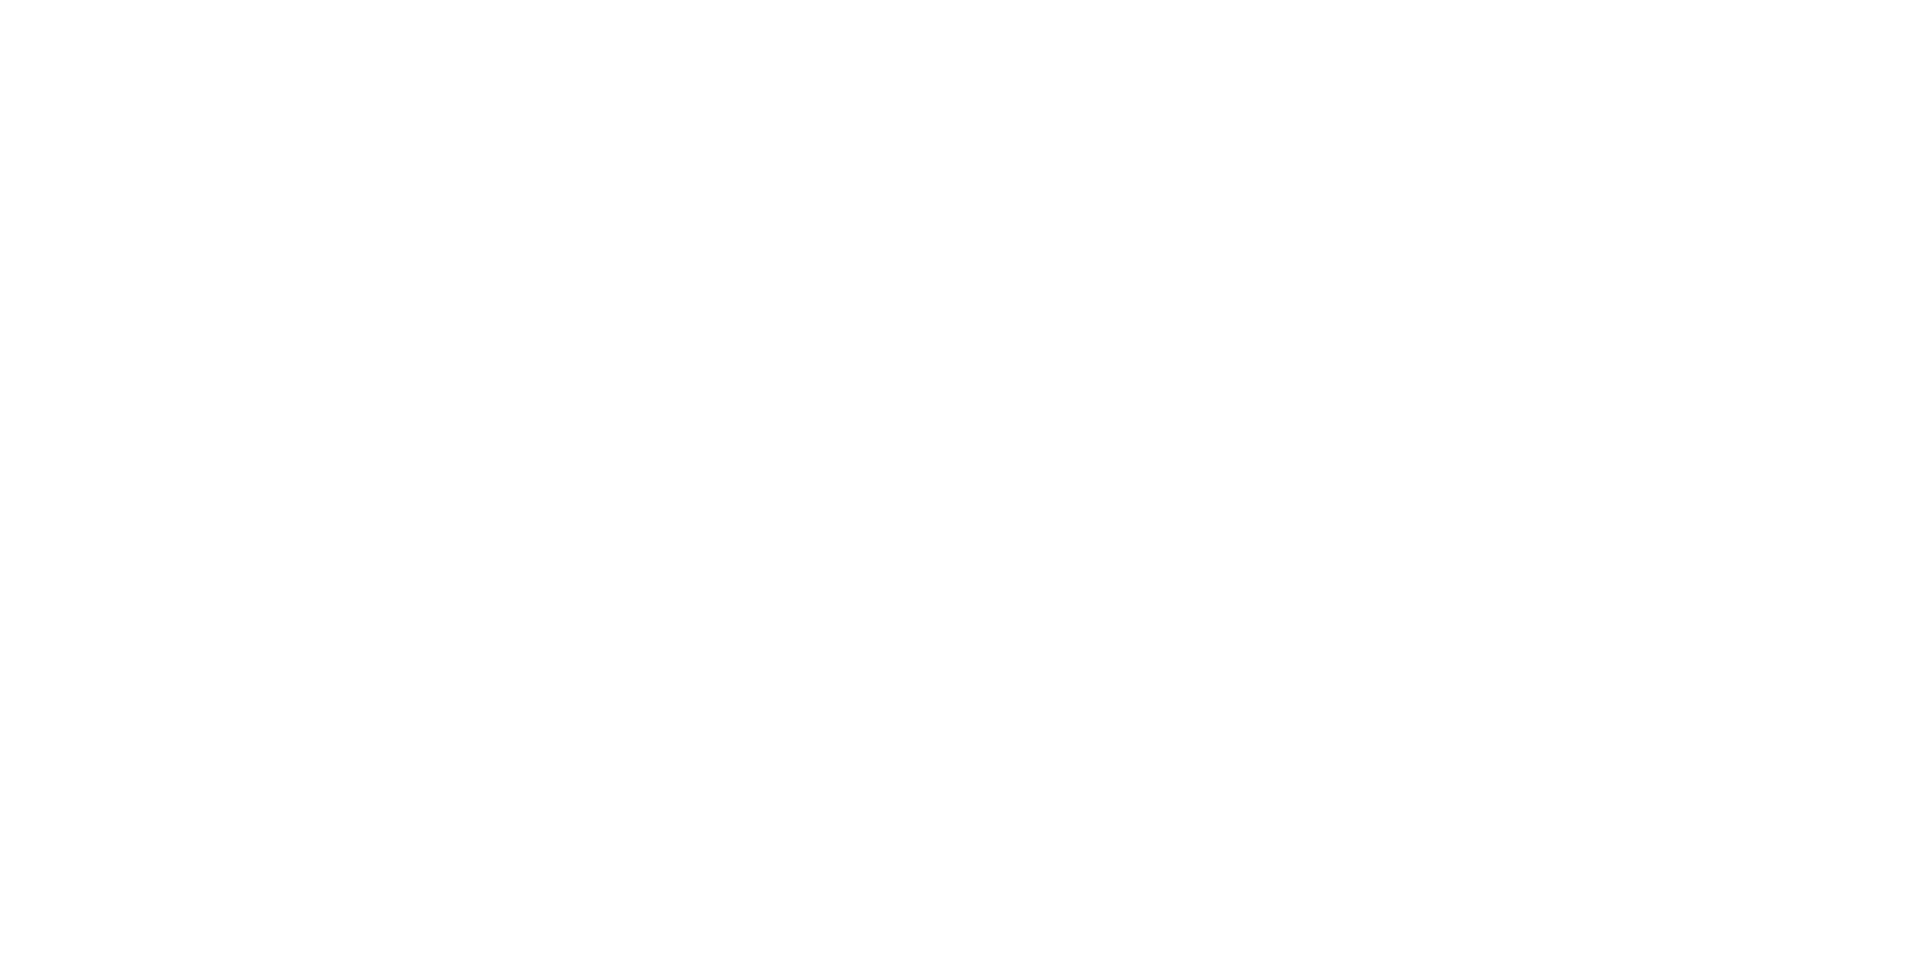

In [3]:
normalized_masks = torch.nn.functional.softmax(output, dim=1).cpu()
# sem_classes = [
#     '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
#     'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
#     'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
# ]
# sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

# car_category = sem_class_to_idx["car"]
car_category = 0
car_mask = normalized_masks[0, :, :, :].argmax(axis=0).detach().cpu().numpy()
car_mask_uint8 = 255 * np.uint8(car_mask == car_category)
car_mask_float = np.float32(car_mask == car_category)

# print(Image.fromarray(car_mask_uint8[:, :, None]))

both_images = np.hstack(( np.repeat(car_mask_uint8[:, :, None], 3, axis=-1)))
Image.fromarray(both_images)
# Image.fromarray(np.repeat(car_mask_uint8[:, :, None])

To apply a class activation method here, we need to decide about a few things:
    - What layer (or layers) are we going to work with?
    - What's going to be the target we want to maximize?

We're going to chose backbone.layer4 as an arbitrary choice that can be tuned.
You can print(model) and see which other layers you might want to try.

As for the target, we're going to take all the pixels that belong to the "car" category, and sum their predictions.

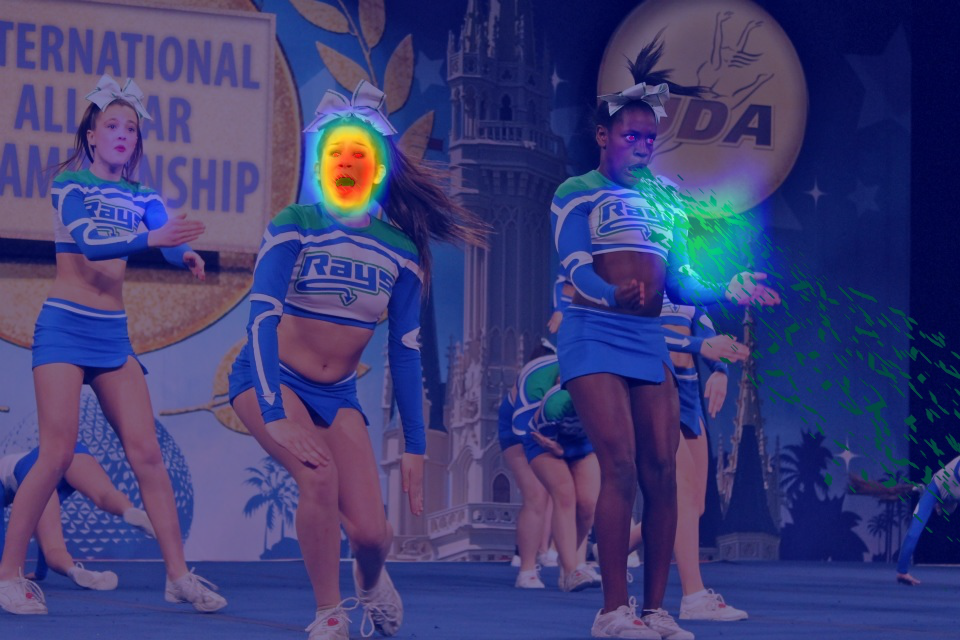

In [5]:
from pytorch_grad_cam import GradCAM

class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()
        
    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()

    
target_layers = [model.head.conv_p2]
targets = [SemanticSegmentationTarget(car_category, car_mask_float)]
with GradCAM(model=model,
             target_layers=target_layers,
             use_cuda=torch.cuda.is_available()) as cam:
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)[0, :]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Image.fromarray(cam_image)
    

Notice how we're getting pixels outside the otirinal masks as well. This is because every pixel is affected by it's sourrounding pixels as well.